<a href="https://colab.research.google.com/github/CienciaDatosUdea/002_EstudiantesAprendizajeEstadistico/blob/main/semestre2025-1/Sesiones/Sesion_11_SVM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Máquinas de Soporte Vectorial SVM

Sección 2.4.3 en https://arxiv.org/pdf/2204.04198

Este es un modelo con origenes que se remontan a los 60's y que se creó desde un punto de vista geométrico. Con este se puede llegar por un camino diferente a la función de coste y regularización a los que llegamos por el método Maximum Likelihood Estimator.

Empecemos con un problema de clasificación de unos datos cuyo i-esimos record $X^{(i)}$ tiene dos variables y que queremos predecir si pertenecen a una clase +1 y 0. El modelo de clasificación se condensa en tres parámetros $\theta_0,\theta_1,\theta_2$ que definen una linea (un hiperplano cuando pensemos en más dimensiones) a través de la ecuación $\theta^T X + \theta_0 = 0$ con $ \theta=(\theta_1,\theta_2)$. Los puntos de la linea son los puntos perpendiculares a $ \theta$. Los puntos del plano quedan clasificados por la región respecto por el signo que resulta del producto escalar $\theta^T X$. Si este producto es positivo están en la región que definimos como de clase +1 y si es negativo en la región definida como clase 0. Con solo argumentos de geometría se demuestra que encontrar los mejores parámetros para un conjunto de datos equivale a minimizar una función de coste parecida a las encontradas anteriormente.

La cantidad principal es la menor distancia que hay entre un punto cualquiera del plano (x1,x2) y el plano del modelo $\theta^T X + \theta_0 = 0$. Esta distancia está dada por $$ d(x, \theta) = \frac{\theta^T x + \theta_0}{| \theta |} $$
El problema de encontrar un buen hiperplano de clasificación consiste entonces en encontrar un conjunto de parámetros que la distancia al hiperplano sea tan grande como pósible o al menos mas grande que una región que escribiremos como $M | \theta |$ es decir resolver que para todo i se cumpla:
$$ y_i (\theta^T x + \theta_0) \ge  M | \theta | $$

Ahora, para simplificar, reescalamos $\theta$ con $ | \theta | = {1}{M}$ tal que la el problema a solucionar se convierte en $$ y_i (\theta^T x + \theta_0) \ge  1 $$

Este reescalamiento hace que buscar que M sea tan grande como posible se convierte en el problema de buscar $| \theta |$ sea tan pequeño como posible. El problema de encontrar el mejor modelo de clasificiación es ahora entonces minimizar $| \theta |$ con la condición que $ y_i (\theta^T x + \theta_0) \ge  1 $ para todo i. Esto se logra por el método de Lagrange. Buscamos minimizar:

$$ L = \frac{1}{2} | \theta |^2 - \sum_i [ \alpha_i  y_i (\theta^T x + \theta_0) -  1 ] $$

Observermos que los terminos se parecen a los que llegamos por MLE. El primero disminuye la complejidad y el segundo término depende del error que se comete en la clasificación. En una libreria como sklearn la siguiente función de coste se llamaría con un parámetro $C$ que multiplicaría el segundo termino. Con esto podemos graduar que tanta importancia se le da al segundo término sobre el primero:

Hay mas detalles técnicos a tener en cuenta que si lo necesitan pueden consultar en estas notas por ejemplo:
https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf




Librerías:

In [43]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.datasets import make_circles
from sklearn.datasets import make_blobs
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.datasets import make_moons, make_circles, make_blobs





In [27]:
# Libraries for draw contours
def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_contoursExact(ax, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


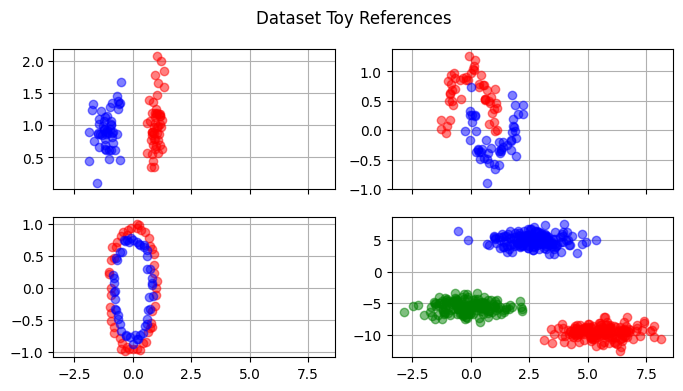

In [36]:
# Dataset Toys References
# https://scikit-learn.org/stable/datasets/toy_dataset.html
# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
# Dataset sinteticos
X0, y0 = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1,
    n_clusters_per_class=1
)
X1, y1 = make_moons(n_samples=100, noise=0.15, shuffle=True,  random_state=1)
X2, y2 = make_circles(n_samples=100, noise=0.05, shuffle=True,  random_state=1)
X3, y3 = make_blobs(n_samples=500, centers=3, n_features=2,shuffle=True,
                    random_state=10)

fig, axs = plt.subplots(2,2, figsize=(8, 4), sharex=True)
fig.suptitle('Dataset Toy References')

axs[0, 0].plot(X0[:,0][y0==0],X0[:,1][y0==0],"ro", alpha=0.5)
axs[0, 0].plot(X0[:,0][y0==1],X0[:,1][y0==1],"bo", alpha=0.5)
axs[0,0].grid()

# Dataset a moons
axs[0, 1].plot(X1[:,0][y1==0],X1[:,1][y1==0],"ro", alpha=0.5)
axs[0, 1].plot(X1[:,0][y1==1],X1[:,1][y1==1],"bo", alpha=0.5)
axs[0, 1].grid()

# Dataset circles

axs[1, 0].plot(X2[:,0][y2==0],X2[:,1][y2==0],"ro", alpha=0.5)
axs[1, 0].plot(X2[:,0][y2==1],X2[:,1][y2==1],"bo", alpha=0.5)
axs[1, 0].grid()

# Dataset circles

axs[1, 1].plot(X3[:,0][y3==0],X3[:,1][y3==0],"ro", alpha=0.5)
axs[1, 1].plot(X3[:,0][y3==1],X3[:,1][y3==1],"bo", alpha=0.5)
axs[1, 1].plot(X3[:,0][y3==2],X3[:,1][y3==2],"go", alpha=0.5)
axs[1, 1].grid()


In [4]:
# Based on :
# https://rramosp.github.io/ai4eng.v1.20211.udea/content/NOTES%2003.03%20-%20SVM%20AND%20FEATURE%20TRANSFORMATION.html

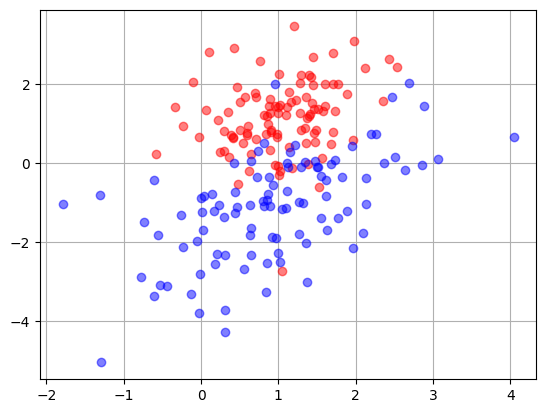

In [37]:
X, y = make_classification(n_samples=200, n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1, shuffle=True)
#X, y = make_circles(n_samples=200, noise=0.1, shuffle=True,  random_state=1)

plt.plot(X[:,0][y==0],X[:,1][y==0],"ro", alpha=0.5)
plt.plot(X[:,0][y==1],X[:,1][y==1],"bo", alpha=0.5)
plt.grid()

Training error:0.880


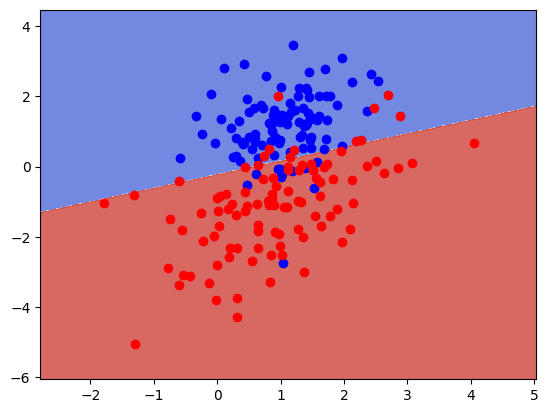

In [6]:
clf = SVC(kernel= 'linear', C=1.0) # C denota la fuerza del segundo termino. C muy pequeño hace que minimizar theta es mas importante
# se vuelven cero, o una constante y a partir de cierto valor ya el segundo termino empiza a tener mas peso
clf.fit(X, y)

#Countour plot
fig, ax = plt.subplots()
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.plot(X[y==0][:,0],X[y==0][:,1],"bo", alpha=1)
plt.plot(X[y==1][:,0],X[y==1][:,1],"ro", alpha=1)
print(f"Training error:{clf.score(X, y):.3f}")


# Métodos de Kernel

Los métodos de Kernel transforman los datos en un espacio en el cual ellos tienen posibilidad de ser separados. Por ejemplo los circulos no hay manera que una frontera lineal los separe. Mas concretamente se trata de hacer una transformación $x \to \phi(x)$. Se determina una nueva función de coste que en vez de depender de $x_i$ va a depender de $\phi(x_i)$. El nombre de método de kernel viene del hecho del reemplazo
$$  \ket x_i, x_j \bra \to \ket \phi(x_i), \phi(x_j) = K(x_i, x_j) $$
donde se denota el kernel. Vamos a elegir diferentes kernels para los problemas anteriores.

Training error:0.870


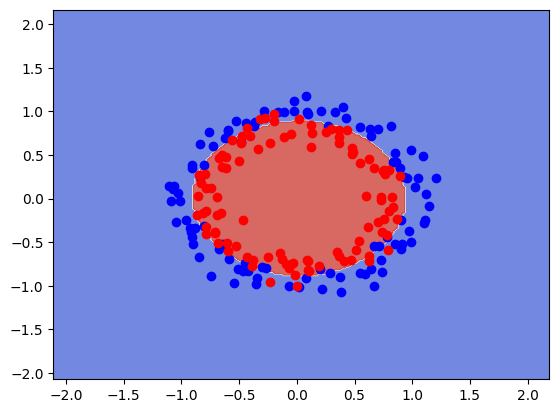

In [7]:
X, y = make_circles(n_samples=200, noise=0.1, shuffle=True,  random_state=1)
clf = SVC(kernel= 'rbf', gamma=1) # El parametro gamma es un parametro relacionado con la complejidad del kernel
clf.fit(X, y)

#Countour plot
fig, ax = plt.subplots()
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.plot(X[y==0][:,0],X[y==0][:,1],"bo", alpha=1)
plt.plot(X[y==1][:,0],X[y==1][:,1],"ro", alpha=1)
print(f"Training error:{clf.score(X, y):.3f}")


# Grid Search of parameter in SVM

Grid-search is used to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions.
https://towardsdatascience.com/grid-search-for-model-tuning-3319b259367e

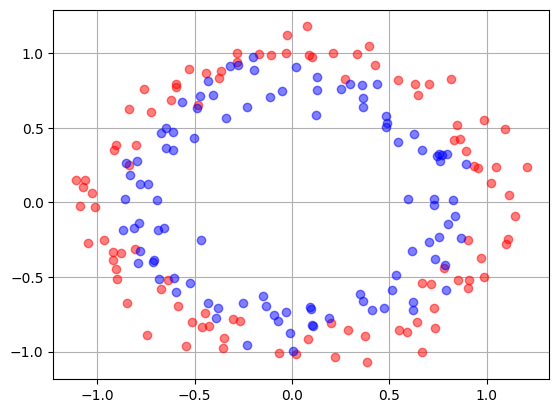

In [38]:
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
from sklearn.model_selection import GridSearchCV


X, y = make_circles(n_samples=200, noise=0.1, shuffle=True,  random_state=1)

plt.plot(X[:,0][y==0],X[:,1][y==0],"ro", alpha=0.5)
plt.plot(X[:,0][y==1],X[:,1][y==1],"bo", alpha=0.5)
plt.grid()

In [9]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

clf = GridSearchCV(estimator=SVC(),
             param_grid = parameters)

clf.fit(X, y)
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [10]:
clf.cv_results_

{'mean_fit_time': array([0.00606112, 0.00392289, 0.00364852, 0.00352426]),
 'std_fit_time': array([3.29736042e-03, 8.05208740e-04, 5.95538877e-05, 1.41565829e-04]),
 'mean_score_time': array([0.0023706 , 0.0026444 , 0.00233374, 0.00339265]),
 'std_score_time': array([0.00067712, 0.00063747, 0.00053635, 0.00240229]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value=999999),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value=np.str_('?'),
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'}],
 'split0_test_score': array([0.275, 0.9  , 0.275, 0.9  ]),
 'split1_test_score': array([0.4  , 0.875, 0.4  , 0.9  ]),
 'split2_test_score': array([0.325, 0.725, 0.325, 0.725]),
 'split3_test_score': array([0.525, 0.8  , 0.525, 0.9  ]),
 'split

In [11]:
clf.best_estimator_

SVC(C=10)

In [12]:
clf.best_params_

{'C': 10, 'kernel': 'rbf'}

In [13]:
clf.best_score_

np.float64(0.8699999999999999)

Training error:0.880


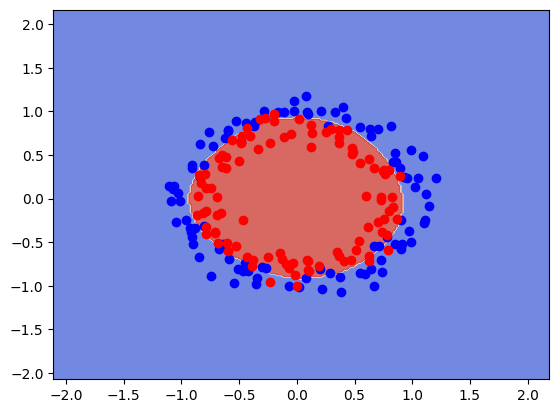

In [14]:
#Countour plot
fig, ax = plt.subplots()
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.plot(X[y==0][:,0],X[y==0][:,1],"bo", alpha=1)
plt.plot(X[y==1][:,0],X[y==1][:,1],"ro", alpha=1)
print(f"Training error:{clf.score(X, y):.3f}")


In [16]:
#Data
X, y = make_circles(n_samples=1000, noise=0.1, shuffle=True,  random_state=1)

#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1080)

#Scaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


Best estimator: SVC(C=1)
Parameters: {'C': 1, 'kernel': 'rbf'}
Accuracy: 0.8387499999999999


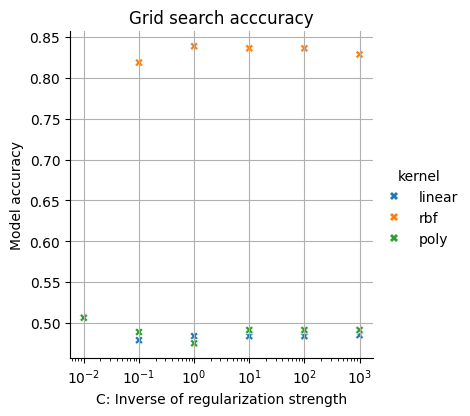

In [42]:
#Grid search
parameters = {'kernel':('linear', 'rbf','poly'), 'C':[0.01, 0.1, 1, 10, 100, 1000]}


classifier = GridSearchCV(estimator = SVC(),
                          param_grid = parameters,
                          scoring='accuracy')
classifier.fit(X_train_scaled, y_train)

#Grid search plots and print
mean_scores = classifier.cv_results_['mean_test_score']
std_scores = classifier.cv_results_['std_test_score']
kernel = classifier.cv_results_['param_kernel']
c = classifier.cv_results_['param_C'].data

scores = {'C': c, 'kernel':kernel, 'mean_test_score': mean_scores, 'std_test_score': std_scores}
scores_df = pd.DataFrame(data = scores)

ax = sns.relplot(data=scores_df,
                 x='C',
                 y='mean_test_score',
                 marker='X',
                 hue='kernel',
                 height=4,
                 aspect=1)

ax.set(title='Grid search acccuracy', xlabel='C: Inverse of regularization strength', ylabel='Model accuracy', xscale = 'log')
ax.ax.grid()

print('Best estimator: '+ str(classifier.best_estimator_))
print('Parameters: ' + str(classifier.best_params_))
print('Accuracy: ' + str(classifier.best_score_))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        95
           1       0.87      0.87      0.87       105

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.86      0.86      0.86       200



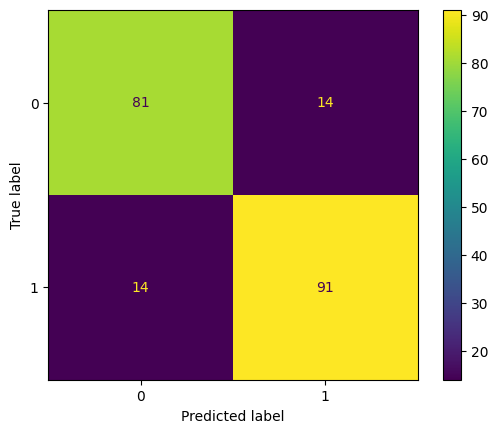

In [18]:
# Model
model = SVC(kernel='rbf', C=1)
model.fit(X_train_scaled,y_train)
# Confusion matrix
y_predict = model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_predict))
cm = metrics.confusion_matrix(y_test, y_predict)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.grid(False)
plt.show()

Tarea 11.1
1. Implementar un SVM para clasificar los siguientes datasets: make_moons, make_circles y make_bloobs, para ello se deberá crear un grid search.
2. Con los mejores párametros dibujar  las fronteras de clasificación
3. Con los mejores parámetros dibujar la matriz de confusion

In [20]:
#  Libraries for draw contours
def make_meshgrid(x, y, h=0.02):
    """Crear una malla de puntos para trazar la frontera de decisión

    Parámetros
    ----------
    x: datos en los que se basa la malla del eje x
    y: datos en los que se basa la malla del eje y
    h: tamaño de la malla, opcional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Trazar los límites de decisión para un clasificador.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: un clasificador
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: diccionario de parámetros para pasar a contourf, opcional
    """
    X_grid = np.c_[xx.ravel(), yy.ravel()]    # Aplanamos la malla para aplicar el modelo
    Z = clf.predict(X_grid)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [21]:
def clasificacion(X, y, name):
  # Separamos los datos en entrenamiento y prueba
  # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

  # split(data a estratificar, variable_objetivo)
  for train_index, test_index in split.split(X, y):
    X_train, y_train = X[train_index], y[train_index]     # Entrenamiento (80%)
    X_test, y_test = X[test_index], y[test_index]         # Prueba (20%)

  # X1, X2 = X_train[:, 0], X_train[:, 1]     # Características
  # y_c = y_train
  X1, X2 = X_test[:, 0], X_test[:, 1]     # Características
  y_c = y_test

  ''' ------------------ Búsqueda del estimador SVC más óptimo ------------------'''
  # Definimos el modelo de clasificación: SVM
  # Buscamos los parámetros más óptimos para el clasificador
  params = {
      'kernel': ('linear','rbf','poly','sigmoid'),
      'C': [0.01, 0.1, 1.0, 10, 15],
      'gamma': ['scale', 'auto', 0.01, 0.1, 1.0, 2]
      }

  # Utilizamos la métrica 'accuracy' por defecto del clasificador SVC
  search = GridSearchCV(estimator=SVC(), param_grid=params)
  search.fit(X_train, y_train)    # Preparamos el modelo con los datos de entrenamiento
  clf = search.best_estimator_

  print('* Parámetros del mejor estimador:', search.best_params_)
  # print('Accuracy (exactitud) del mejor estimador: %.4lf \n' %search.best_score_)
  print('* Accuracy (exactitud) del mejor estimador: %.4lf \n' %clf.score(X_train, y_train))

  clf.fit(X_train, y_train)

  ''' --------------------------- Matriz de confusión ---------------------------'''
  y_pred = clf.predict(X_test)
  cm = metrics.confusion_matrix(y_c, y_pred)

  print('* Métricas del estimador con los datos de prueba:')
  print(metrics.classification_report(y_c, y_pred))

  ''' ------- Gráficos de la clasificación de los datos de entrenamiento --------'''
  fig, axes = plt.subplots(1, 2, figsize=(12, 5))
  fig.suptitle(f'Dataset {name}')

  # GRÁFICO : FRONTERAS DE CLASIFICACIÓN
  axes[0].set_title("Fronteras de decisión (Datos de prueba)")
  axes[0].plot(X1[y_c==0], X2[y_c==0], "bo", alpha=0.5, label='Clase 0')
  axes[0].plot(X1[y_c==1], X2[y_c==1], "ro", alpha=0.5, label='Clase 1')
  axes[0].set_xlabel(r"Característica: $X_1$")
  axes[0].set_ylabel(r"Característica: $X_2$")
  axes[0].legend()
  XX, YY = make_meshgrid(X1, X2)
  plot_contours(axes[0], clf, XX, YY, cmap=plt.cm.coolwarm, alpha=0.8)
  axes[0].legend()

  # Gráfico de la matriz de confusión
  axes[1].set_title("Matriz de confusión")
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot(ax=axes[1])
  axes[1].grid(False)

  plt.show()

* Parámetros del mejor estimador: {'C': 1.0, 'gamma': 2, 'kernel': 'rbf'}
* Accuracy (exactitud) del mejor estimador: 0.9844 

* Métricas del estimador con los datos de prueba:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        40
           1       0.95      0.95      0.95        40

    accuracy                           0.95        80
   macro avg       0.95      0.95      0.95        80
weighted avg       0.95      0.95      0.95        80



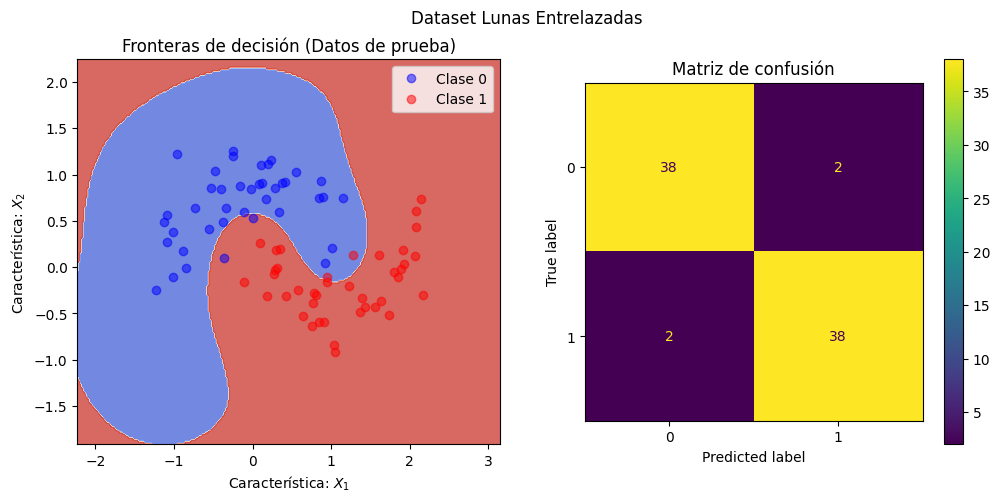

In [22]:
X, y = make_moons(n_samples=400, noise=0.2, shuffle=True, random_state=42)
clasificacion(X, y, 'Lunas Entrelazadas')

* Parámetros del mejor estimador: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
* Accuracy (exactitud) del mejor estimador: 0.9000 

* Métricas del estimador con los datos de prueba:
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        40
           1       0.92      0.90      0.91        40

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80



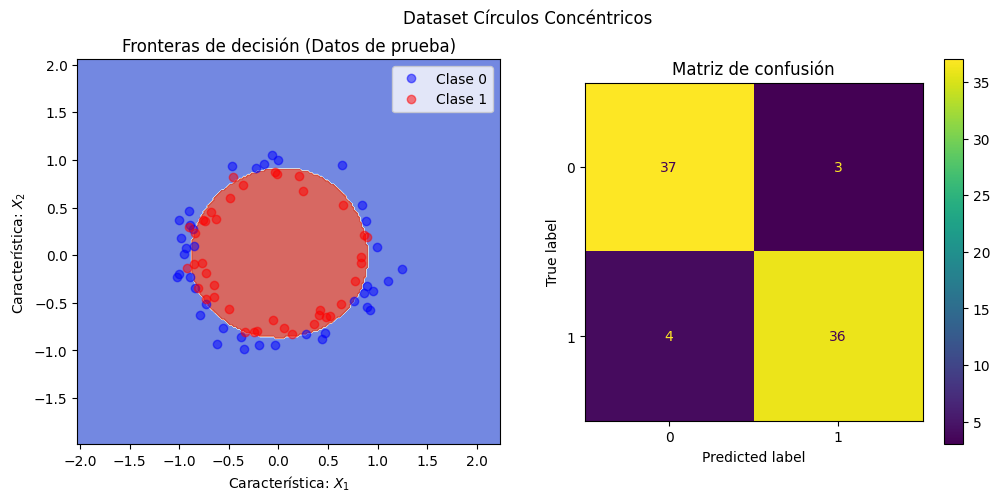

In [23]:
X, y = make_circles(n_samples=400, noise=0.08, shuffle=True, random_state=42)
clasificacion(X, y, 'Círculos Concéntricos')

* Parámetros del mejor estimador: {'C': 0.01, 'gamma': 'auto', 'kernel': 'poly'}
* Accuracy (exactitud) del mejor estimador: 0.9938 

* Métricas del estimador con los datos de prueba:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.98      0.98      0.98        60

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



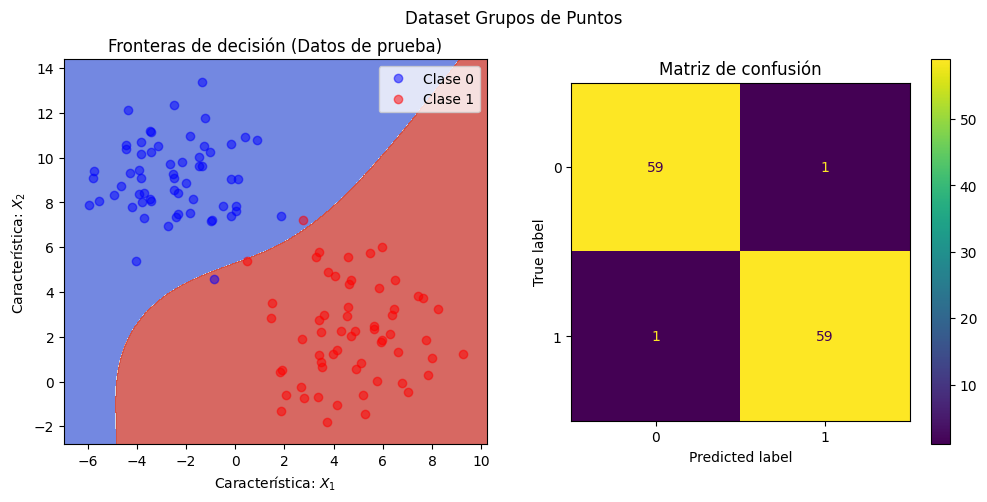

In [24]:
X, y = make_blobs(n_samples=600, centers=2, n_features=2, \
                  cluster_std=[2,2], shuffle=True, random_state=42)
# cluster_std: Agrega una varianza a los datos de cada grupo
clasificacion(X, y, name='Grupos de Puntos')

* Parámetros del mejor estimador: {'C': 15, 'gamma': 'scale', 'kernel': 'rbf'}
* Accuracy (exactitud) del mejor estimador: 0.9667 

* Métricas del estimador con los datos de prueba:
              precision    recall  f1-score   support

           0       0.90      0.98      0.93        44
           1       0.98      0.89      0.93        46

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



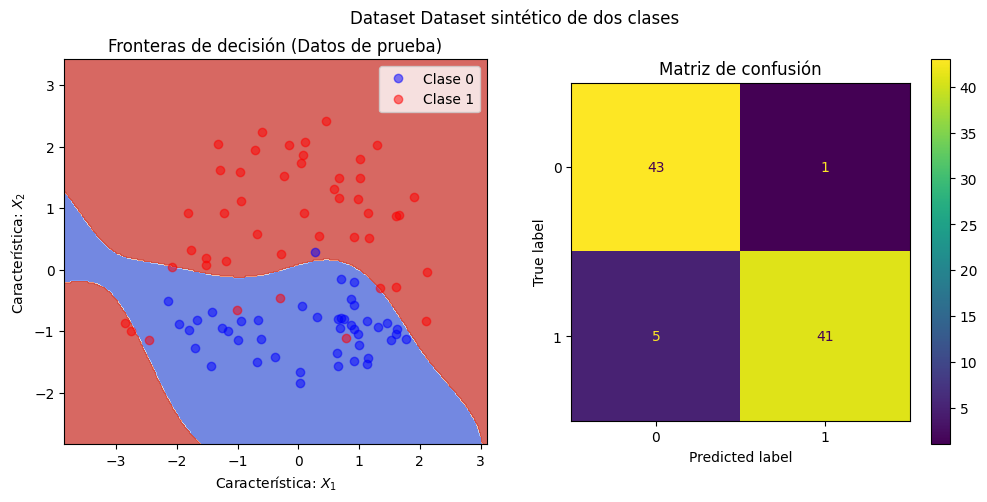

In [25]:
X, y = make_classification(n_samples=450, n_features=2, n_redundant=0, n_informative=2, \
                           random_state=42, n_clusters_per_class=2, shuffle=True)
'''
  n_redundant:
    Este parámetro controla el número de características redundantes (correlacionadas
    con las características informativas). Al aumentar n_redundant, se introduce indirectamente más
    ruido o superposición, ya que las características redundantes pueden dificultar la separación clara de las clases.

  n_clusters_per_class:
    Este parámetro controla el número de grupos o clusters por clase. Si se
    establece en un valor mayor que 1, se crean múltiples clusters para cada clase, lo que puede
    aumentar la superposición y hacer la clasificación más difícil.
'''
clasificacion(X, y, name='Dataset sintético de dos clases')